# Velocity Arrow Plot

This Jupyter/IPython notebook recreates a plot similar to Fig. 4 of [Birnstiel et al. 2016](http://dx.doi.org/10.1007/s11214-016-0256-1). Please cite it when using this notebook. Use [binder](http://mybinder.org/repo/birnstiel/review_arrow_plot) to run it right in your browser.

## Imports

In [1]:
from matplotlib.patches  import Rectangle
from matplotlib          import ticker
from matplotlib.colors   import LogNorm
from IPython.display     import Image,display
from scipy.interpolate   import interp2d
from scipy.integrate     import odeint
from matplotlib          import rcParams
from brewer2mpl          import get_map
from aux                 import *

import numpy             as np
import matplotlib.pyplot as plt

rcParams['axes.linewidth']  = 2
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 15

## Set parameters

In [2]:
M_star = 0.8*M_sun
M_disk = 0.01*M_star
r_d    = 200*AU
r_0    = 0.1*AU
p      = 1 # needed for analytical solution
alpha  = 1e-3
rho_s  = 1.2
v_frag = 1000.
n_m    = 100
n_r    = 200
q      = 0.5
TAU    = 200.
#
# define the dust-to-gas ratio
#
d2g0   = 5e-3 # the dust to gas ratio of the outer disk, using eps ~r**0.25
#eps_f  = lambda r: min(d2g0*(r/r_c)**0.25,d2g0)
eps_f  = lambda r: d2g0

r      = np.logspace(np.log10(r_0/AU),np.log10(r_d/AU),n_r)*AU
a      = np.logspace(-4,3,n_m)
m      = 4*pi/3.*rho_s*a**3 
#
# calculate normalization for sigma_gas
#
sig_norm = (2-p)*M_disk/(2*pi*r_d**2)*(1-(r_0/r_d)**(2-p))**-1

## Calculate trajectories $y(t)$, where $y = [a, r]$

Define lambda functions.

In [3]:
p_g_f   = lambda r: p                                             # gas surface density index
p_v_gas = lambda r: -p_g_f(r)-q+2.                                # index used in the gas velocity
gamma_f = lambda r: -p_g_f(r)-(q+3.)/2.                           # pressure index
sig_g_f = lambda r: sig_norm*(r/r_d)**-p                          # gas surface density
T_f     = lambda r: 200*(r/AU)**-0.5                              # temperature
cs_f    = lambda r: np.sqrt(k_b*T_f(r)/mu/m_p)                    # sound speed
om_f    = lambda r: np.sqrt(Grav*M_star/r**3)                     # kepler velocity
v_g_f   = lambda r: -3*alpha*cs_f(r)**2/om_f(r)/r*p_v_gas(r)      # gas velocity

In [70]:
St_f    = lambda r,a: a*rho_s/sig_g_f(r)*pi/2.                                         # Stokes number
v_gd_f  = lambda r,a: 1./(1.+St_f(r,a)**2)*v_g_f(r)                                    # gas drag velocity
v_dr_f  = lambda r,a: 1./(St_f(r,a)+St_f(r,a)**-1)*(cs_f(r)**2/(r*om_f(r))*gamma_f(r)) # drift velocity
v_t_f   = lambda r,a: v_dr_f(r,a) + v_gd_f(r,a)                                        # total dust velocity
         
a_fr_f  = lambda r:  2./(3.*pi)*sig_g_f(r)/(rho_s*alpha)*v_frag**2/cs_f(r)**2          #  simple frag. barrier
a_st_f  = lambda r: 2*sig_g_f(r)/(pi*rho_s)                                            # St=1 line
a_dr_f  = lambda r: 0.55*2*sig_g_f(r)*eps_f(r)*r**2*om_f(r)**2/ \
                    (pi*rho_s*cs_f(r)**2*abs(gamma_f(r)))                              # drift limit

b       = lambda r: 3.*alpha*(cs_f(r)/v_frag)**2                                       # quadratic fragmentation barrier
a_fr_f2 = lambda r: sig_g_f(r)/(pi*rho_s)*(b(r)-np.sqrt(b(r)**2-4.))

#
# drift velocity
#
drdt    = lambda r,a: v_t_f(r,a) * (r > 0)
#
# growth rate, using hd = hg*min(1,sqrt(alpha/St))
#
dadt = lambda r,a: eps_f(r)*sig_g_f(r)*om_f(r)/rho_s*np.sqrt(3./(2.*pi)) * np.sqrt(alpha/(St_f(r,a)+St_f(r,a)**-1))/min(1.,np.sqrt(alpha/St_f(r,a))) * (r > 0)

Improving some of the functions

In [121]:
#
# growth rate, using hd = hg*min(alpha/(alpha+St))
#
fudge = 0.25
def dadt(r,a):
    St = St_f(r,a)
    return fudge * eps_f(r) * sig_g_f(r) * om_f(r) / rho_s * np.sqrt(3. / (2. * pi)) * np.sqrt((St + alpha) / (St + 1 / St))

In [122]:
rho_g = lambda r: sig_g_f(r) / (np.sqrt(2. * np.pi) * cs_f(r) / om_f(r))
mfp = lambda r: mu * m_p / (np.sqrt(2.) * rho_g(r) * sigma_H2)

def St_f(r, a):
    """calculates the stokes number (Epstein/St1) at radius r, grainsize a"""
    if (a < 2.25 * mfp(r)):
        return 0.5 * np.pi * a * rho_s / sig_g_f(r)
    else:
        return 2./9. * np.pi * a**2 * rho_s / (mfp(r) * sig_g_f(r))

Define Analytical Solution

In [123]:
def sol(r0,a0,t=None,F=1e-2,N=200,t0=1.):
    """
    Calculate the drift+growth trajectory [r(t),a(t)]. If `t` is given, it will calculate
    the solution on that time array, otherwise it will integrate until a time `t1` when the
    trajectory reaches a radius r(t1)=F*r0.
    
    Arguments:
    ----------
    
    r0 : float
    :   initial radius [AU]
    
    a0 : float
    :   initial grain size [cm]
    
    Keywords:
    ---------
    
    t : None|array
    :   the time array on which the solution is calculated, if None: see other keywords
    
    F : float
    :   the fraction of the initial radius until which the integration is carried out
    
    N : int
    :   the number of time snap shots of the solution array
    
    t0 : float
    :   the first time snap shot of the logarithmic time array
    
    Returns:
    --------
    
    sol, t
    
    sol : array
    :   sol[:,0] are the radii r(t)             [cm]
        sol[:,1] are the grain sizes a(t)       [cm]
        t[:]     are the times of the snapshots [s]
    """
    A = a0*rho_s*pi/2./sig_g_f(r0)*(cs_f(r0)/om_f(r0)/r0)**2*om_f(r0)*gamma_f(r0)
    B = eps_f(r0)*om_f(r0)
    
    if t is None:
        t1 = (2.*np.log(-((3.*A + 2.*B)*((2.*B)/(3.*A + 2.*B) - F**1.5))/(3.*A)))/(3.*A + 2.*B)
        t  = np.append(0,np.logspace(np.log10(t0),np.log10(t1 / fudge),N))
        

    x = lambda t: (   (2.*B+3.*A*np.exp(1.5*A*t+B*t)) / (3.*A+2.*B)  )**(2./3.)
    y = lambda t: ((3.*A + 2.*B)*np.exp((3.*A*t)/2. + B*t))/(2.*B + 3.*A*np.exp((3.*A*t)/2. + B*t))
    return np.array([a0*y(t),r0*x(t)]).T,t

## Integration: analytical solution

In [124]:
from scipy.integrate import solve_ivp

In [125]:
SOL  = []
SOLT = []
SOLA = []
for r0 in [1,10,100]:
    print('r0 = {} AU'.format(r0))
    r0   = r0*AU
    a0   = 1e-4
    y0   = np.array([a0,r0])
    #
    #  define the derivative dy/dt and integrate
    #
    dydt  = lambda t, y: [dadt(y[1], y[0]), drdt(y[1], y[0])]
    s,tt  = sol(r0,a0,N=500,F=0.5e-2)
    SOL  += [s]
    SOLT += [tt]
    res = solve_ivp(dydt, [0, tt[-1]], y0, t_eval=tt)
    if not res['success']:
        raise ValueError(res['message'])
    SOLA += [res]

r0 = 1 AU
r0 = 10 AU
r0 = 100 AU


<ipython-input-123-c25aa63a41c0>:49: RuntimeWarning: invalid value encountered in power
  x = lambda t: (   (2.*B+3.*A*np.exp(1.5*A*t+B*t)) / (3.*A+2.*B)  )**(2./3.)
<ipython-input-3-3ee2fa1d2ac8>:5: RuntimeWarning: invalid value encountered in double_scalars
  T_f     = lambda r: 200*(r/AU)**-0.5                              # temperature
<ipython-input-3-3ee2fa1d2ac8>:7: RuntimeWarning: invalid value encountered in sqrt
  om_f    = lambda r: np.sqrt(Grav*M_star/r**3)                     # kepler velocity


## Plot the velocity arrows and trajectories

In [126]:
a_grid, r_grid = np.meshgrid(a, r)
St_grid = np.vectorize(St_f)(r_grid, a_grid)

<ipython-input-70-74c38f8c7c0a>:12: RuntimeWarning: invalid value encountered in sqrt
  a_fr_f2 = lambda r: sig_g_f(r)/(pi*rho_s)*(b(r)-np.sqrt(b(r)**2-4.))


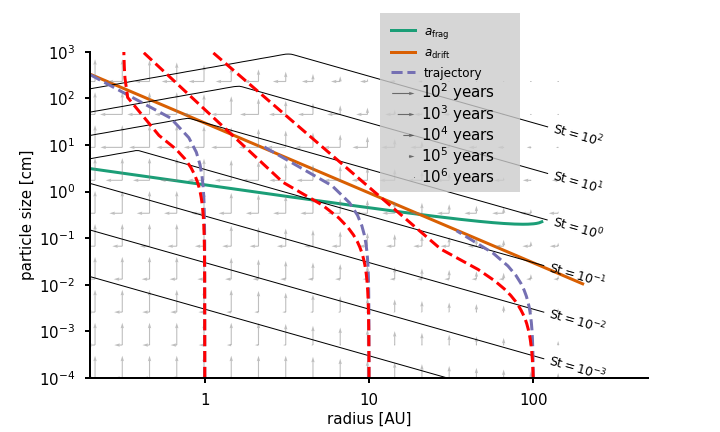

In [127]:
cols = get_map('Dark2', 'Qualitative', 3).mpl_colors
plt.style.use([{
            'lines.linewidth': 3,
            'axes.spines.right': False,
            'axes.spines.top': False,
            'xtick.major.pad':  10.0,
            'xtick.major.size':  5.0,
            'xtick.major.width':  2,
            'ytick.major.pad':  10.0,
            'ytick.major.size':  5.0,
            'ytick.major.width':  2,
        }])

dadt_v  = np.vectorize(dadt)
v_t_f_v = np.vectorize(v_t_f)

i_q = 10
X,Y = np.meshgrid(r, a)
U   = r[np.newaxis,:] / v_t_f_v(*np.meshgrid(r, a)) / year                 # drift time scale in years
V   = a[:,np.newaxis] / dadt_v(*np.meshgrid(r, a)) / year # growth time scale in years
#
# limit to between 1e3 and 1e6 years
#
U   = np.sign(U) * np.maximum(np.minimum(abs(U), 1e6), 1e2)
V   = np.sign(V) * np.maximum(np.minimum(abs(V), 1e6), 1e2)
# scale such that 0 = 1e6
#                 1 = 1e5
#                 2 = 1e4
#                 3 = 1e3
#                 4 = 1e2
Vs = (6 - np.log10(np.abs(V))) * np.sign(V)
Us = (6 - np.log10(np.abs(U))) * np.sign(U)
#
# set quiver properties
#
props={'scale': 1 / 0.01, 'units': 'width', 'width': 0.002, 'alpha': 0.5}
#
# draw the arrows
#
f,ax = plt.subplots(figsize=(10, 6))
Qlr = ax.quiver(X[::i_q, ::i_q] / AU, Y[::i_q, ::i_q], Us[::i_q, ::i_q], np.zeros(Vs[::i_q, ::i_q].shape), color='0.5', **props)
Qud = ax.quiver(X[::i_q, ::i_q] / AU, Y[::i_q, ::i_q], np.zeros(Us[::i_q ,::i_q].shape), Vs[::i_q, ::i_q], color='0.5', **props)
#Qb  = ax.quiver(X[::i_q,::i_q]/AU,Y[::i_q,::i_q],Us[::i_q,::i_q],Vs[::i_q,::i_q],color='r',alpha=0.5,**props)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('radius [AU]')
ax.set_ylabel('particle size [cm]')
ax.set_xlim(0.2, 500);
ax.set_ylim(a[0], a[-1]);
#
# draw stokes number
#
levels = 10.**np.arange(-4, 3)
cc = ax.contour(r_grid / AU, a_grid, St_grid, levels=levels, norm=LogNorm(1e-5, 1e3), colors='k', linewidths=1)
plt.clabel(cc, levels,
    fmt=lambda v: f'$\mathsf{{St}} = 10^{{{np.log10(v):.0f}}}$', fontsize='small',
    manual=[(200, .4e-3),
            (200, .4e-2),
            (200, .4e-1),
            (200, .4e0),
            (200, .4e1),
            (200, .4e2),
           ])#,
    #inline_spacing=-15)


#
# draw lines
#
#ax.loglog(r/AU,a_st_f(r),'k',  zorder=0,label='St=1')
ax.loglog(r / AU, a_fr_f2(r), '-', zorder=0, c=cols[0], lw=3, label='$a_\mathrm{frag}$')
ax.loglog(r / AU, a_dr_f(r), '-',  zorder=0, c=cols[1], lw=3, label='$a_\mathrm{drift}$')
#
# draw trajectories
#
for i,(s, tt, s_ana) in enumerate(zip(SOL, SOLT, SOLA)):
    ax.loglog(s[:,1] / AU, s[:,0], '--', c=cols[2], lw=3, label=(i==1) * 'trajectory')
    ax.loglog(s_ana['y'][1, :] / AU, s_ana['y'][0,:], 'r--', lw=3)
#
# draw box for scale arrows
#
xo,yo=0.52, 0.55
rect = plt.Rectangle((xo, yo + 0.02), 0.25, 0.55, facecolor="0.8", alpha=0.8, transform=ax.transAxes, zorder=3, clip_on=False)
ax.minorticks_off()
ax.add_patch(rect)
#
# draw scale arrows
#
kprops={'labelpos':'E','color':'k','alpha':0.5}
qk1 = plt.quiverkey(Qlr, xo + 0.06, yo + 0.065 * 5, 4, r'$10^2$ years', **kprops)
qk2 = plt.quiverkey(Qlr, xo + 0.06, yo + 0.065 * 4, 3, r'$10^3$ years', **kprops)
qk3 = plt.quiverkey(Qlr, xo + 0.06, yo + 0.065 * 3, 2, r'$10^4$ years', **kprops)
qk4 = plt.quiverkey(Qlr, xo + 0.06, yo + 0.065 * 2, 1, r'$10^5$ years', **kprops)
qk5 = plt.quiverkey(Qlr, xo + 0.06, yo + 0.065 * 1, 0, r'$10^6$ years', **kprops)
for qk in [qk1, qk2, qk3, qk4, qk5]:
    qk.set_zorder(4)
plt.legend(loc=(0.53, 0.9), fontsize=12).get_frame().set_alpha(0)
#
# save figure
#
ax.set_facecolor('none')
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.minorticks_off()
plt.savefig('velocity_arrows.pdf', facecolor='none')
plt.savefig('velocity_arrows.png', facecolor='none')
plt.close()
display(Image(filename='velocity_arrows.png'))